In [1]:
import numpy as np
import pymc3 as pm
import scipy
from scipy import constants
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from astropy import constants as const
matplotlib.rcParams.update({'font.size': 17,"axes.labelsize": 17})

# Load the eclipse depth and temperature data from Garhart 2020

In [4]:
filename='garhart2020.csv'
garhartDF = pd.read_csv(filename)

Remove the planets that don't have a Ch1 eclipse depth

In [5]:
garhartDF=garhartDF.drop([18,24])

In [6]:
#Split the Tb columns into two
garhartDF[['4.5 μm Tb','4.5 μm Tb err']]=garhartDF['4.5 μm Tb'].str.split('±',expand=True).astype('float')
garhartDF[['3.6 μm Tb','3.6 μm Tb err']]=garhartDF['3.6 μm Tb'].str.split('±',expand=True).astype('float')
garhartDF[['T eq','T eq err']] =garhartDF['Equilibrium temperature'].str.split('±',expand=True).astype('float')

In [7]:
garhartDF

,Planet,Equilibrium temperature,3.6 μm Tb,4.5 μm Tb,4.5 μm Tb err,3.6 μm Tb err,T eq,T eq err
0,HAT-13,1653± 50,1810.0,1754.0,200.0,229.0,1653.0,50.0
1,HAT-30,1718± 34,2087.0,1938.0,160.0,140.0,1718.0,34.0
2,HAT-33,1855± 148,2112.0,1990.0,209.0,162.0,1855.0,148.0
3,HAT-40,1771± 38,2074.0,1887.0,259.0,354.0,1771.0,38.0
4,HAT-41,1685± 58,1694.0,1622.0,125.0,294.0,1685.0,58.0
5,KELT-2,1721± 36,1994.0,1782.0,111.0,104.0,1721.0,36.0
6,KELT-3,1829± 42,2445.0,2132.0,133.0,133.0,1829.0,42.0
7,KELT-7,2056± 31,2512.0,2415.0,73.0,69.0,2056.0,31.0
8,Qatar-1,1422± 36,1410.0,1532.0,219.0,425.0,1422.0,36.0
9,WASP-12,2546± 82,3329.0,2934.0,114.0,172.0,2546.0,82.0


# Reformat this a bit to make it play nicer with PYMC3
"Stack" the data so that I can use a single Normal distribution for both channels, and create indices. This makes my life easier when I want to compare the WAIC, LOO, etc. etc. Give a unique index for each planet name, and for the Spitzer IRAC Channel.

In [8]:
ch2DF=garhartDF[['Planet','4.5 μm Tb','4.5 μm Tb err','T eq','T eq err']].copy()
ch1DF=garhartDF[['Planet','3.6 μm Tb','3.6 μm Tb err','T eq','T eq err']].copy()
ch2DF.columns= ['Planet','Tday','Terr','T eq','T eq err']
ch1DF.columns= ['Planet','Tday','Terr','T eq','T eq err']
ch2DF['Planet Ind']=np.arange(0,37)
ch2DF['Channel']=np.ones(37,dtype=int)*0
ch1DF['Planet Ind']=np.arange(0,37)
ch1DF['Channel']=np.ones(37,dtype=int)*1

In [9]:
df_cleaned=pd.concat([ch2DF,ch1DF])

In [10]:
pd.set_option('display.max_rows', 1000)

In [11]:
df_cleaned

,Planet,Tday,Terr,T eq,T eq err,Planet Ind,Channel
0,HAT-13,1754.0,200.0,1653.0,50.0,0,0
1,HAT-30,1938.0,160.0,1718.0,34.0,1,0
2,HAT-33,1990.0,209.0,1855.0,148.0,2,0
3,HAT-40,1887.0,259.0,1771.0,38.0,3,0
4,HAT-41,1622.0,125.0,1685.0,58.0,4,0
5,KELT-2,1782.0,111.0,1721.0,36.0,5,0
6,KELT-3,2132.0,133.0,1829.0,42.0,6,0
7,KELT-7,2415.0,73.0,2056.0,31.0,7,0
8,Qatar-1,1532.0,219.0,1422.0,36.0,8,0
9,WASP-12,2934.0,114.0,2546.0,82.0,9,0


# Scale the dayside temperature by dividing by the irradiation temperature and add this as a new column

In [14]:
# Scale the temperatures to get m values
df_cleaned['m']=df_cleaned['Tday']/df_cleaned['T eq']*0.25**0.25
df_cleaned['m err']=df_cleaned['Terr']/df_cleaned['T eq']*0.25**0.25


In [15]:
df_cleaned

,Planet,Tday,Terr,T eq,T eq err,Planet Ind,Channel,m,m err
0,HAT-13,1754.0,200.0,1653.0,50.0,0,0,0.750312,0.085554
1,HAT-30,1938.0,160.0,1718.0,34.0,1,0,0.797656,0.065854
2,HAT-33,1990.0,209.0,1855.0,148.0,2,0,0.758567,0.079669
3,HAT-40,1887.0,259.0,1771.0,38.0,3,0,0.753422,0.103411
4,HAT-41,1622.0,125.0,1685.0,58.0,4,0,0.680669,0.052456
5,KELT-2,1782.0,111.0,1721.0,36.0,5,0,0.732170,0.045607
6,KELT-3,2132.0,133.0,1829.0,42.0,6,0,0.824249,0.051419
7,KELT-7,2415.0,73.0,2056.0,31.0,7,0,0.830575,0.025106
8,Qatar-1,1532.0,219.0,1422.0,36.0,8,0,0.761806,0.108900
9,WASP-12,2934.0,114.0,2546.0,82.0,9,0,0.814867,0.031661


# The non-hierarchical model

In [16]:
with pm.Model() as model_sep:
    m_offset = pm.Normal('m offset',0,1,shape=len(df_cleaned.index))
    m = pm.Deterministic('m',0.70+0.175*3*m_offset)
    #Calculate the brightness temp ratio
    ratio =pm.Deterministic('ratio',m[0:37]/m[37:74])
    #Convert m to brightness temp
    #Tday = pm.Deterministic('Tday',m*Teff[2::]*np.sqrt(1/a[2::]))
    #ED= pm.Deterministic('ED',Planck(4.5e-6,Tday)/BStarCh2[2::]*radius[2::]**2)
    y_ = pm.Normal('y',mu=m , sd=df_cleaned['m err'],observed= df_cleaned['m'])

# Plot predictive posterior check to make sure the priors are giving reasonable values.

In [17]:
with model_sep:
    ppc_sep =pm.sample_prior_predictive(samples=1000)

Text(0.5, 0, '$T_{0}$')

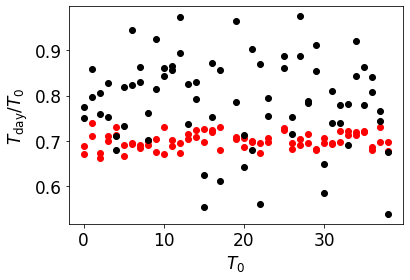

In [36]:
plt.scatter(x=df_cleaned.index,y=np.median(ppc_sep['m'],axis=0),color='red')
plt.scatter(x=df_cleaned.index,y=df_cleaned['m'],color='k')
plt.ylabel(r'$T_{\rm day}/T_{0}$')
plt.xlabel(r'$T_{0}$')

# Fit and sample the separate model. We expect this to just reproduce the published results.

In [19]:
with model_sep:
    trace_sep =pm.sample(draws=1000,tune=1000,chains=4,cores=4,target_accept=0.95)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [m offset]
Sampling 4 chains, 0 divergences: 100%|██████████| 8000/8000 [00:25<00:00, 308.45draws/s]


In [20]:
summary=pm.summary(trace_sep,var_names=['m'],round_to=7)

In [21]:
summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
m[0],0.749016,0.082812,0.588048,0.902790,0.000741,0.000538,12491.770262,11859.851829,12490.625294,3045.706852,1.001475
m[1],0.796187,0.067276,0.671979,0.927027,0.000687,0.000488,9589.752604,9520.902340,9624.153478,2615.779054,1.000721
m[2],0.757154,0.078021,0.609248,0.901813,0.000704,0.000521,12280.815339,11235.342191,12264.237318,2376.685080,1.000987
m[3],0.752641,0.105189,0.557479,0.950403,0.000935,0.000703,12649.469096,11195.264604,12650.263280,2980.824315,1.000814
m[4],0.681079,0.052173,0.582396,0.776490,0.000516,0.000368,10215.715170,10030.959591,10178.441656,2992.805973,0.999865
m[5],0.731535,0.043684,0.646526,0.811252,0.000457,0.000323,9132.051739,9132.051739,9129.899907,2930.046998,1.002873
m[6],0.822444,0.051847,0.731875,0.926811,0.000505,0.000357,10526.465502,10526.465502,10532.711533,3322.087986,1.000181
m[7],0.830457,0.025235,0.785226,0.878738,0.000241,0.000171,10937.931695,10934.925921,10856.194345,2828.701551,1.000571
m[8],0.759323,0.109544,0.544390,0.956132,0.001028,0.000777,11344.424714,9942.524558,11334.658100,2475.962996,0.999629
m[9],0.814672,0.031142,0.753052,0.869582,0.000312,0.000221,9948.724828,9897.078851,9995.802358,2572.422535,1.000467


Text(0.5, 0, '$T_{0}$')

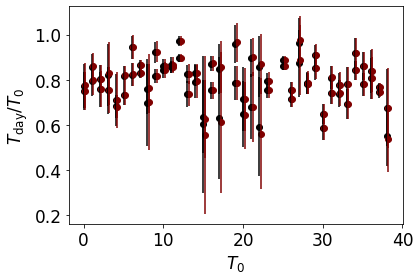

In [23]:
plt.errorbar(x=df_cleaned.index,y=summary['mean'],yerr=summary['sd'],linestyle='None',color='k')
plt.scatter(x=df_cleaned.index,y=summary['mean'],color='k')
plt.errorbar(x=df_cleaned.index+0.2,y=df_cleaned['m'],yerr=df_cleaned['m err'],linestyle='None',color='maroon')
plt.scatter(x=df_cleaned.index+0.2,y=df_cleaned['m'],color='maroon')
plt.ylabel(r'$T_{\rm day}/T_{0}$')
plt.xlabel(r'$T_{0}$')

In [24]:

summary_ratio=pm.summary(trace_sep,var_names=['ratio'],round_to=7)


In [25]:
summary_ratio

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
ratio[0],0.985616,0.170186,0.690404,1.304393,0.001742,0.001356,9543.579637,7881.418310,10286.829311,3034.600324,1.001671
ratio[1],0.932173,0.101059,0.751694,1.130208,0.000980,0.000722,10627.392754,9809.532225,10310.255173,2904.598737,1.004055
ratio[2],0.947800,0.123477,0.710465,1.172000,0.001150,0.000837,11531.846567,10893.511091,11363.378956,2418.766444,1.001459
ratio[3],0.945890,0.217734,0.550810,1.348665,0.002439,0.002027,7967.189167,5768.543668,9999.768252,2751.394293,1.000389
ratio[4],0.985255,0.188131,0.672152,1.329340,0.002251,0.001807,6983.413989,5421.180443,9015.690544,3066.126277,0.999717
ratio[5],0.896373,0.070345,0.763442,1.020837,0.000701,0.000509,10073.104395,9529.898468,10403.002891,2930.554927,1.003095
ratio[6],0.873873,0.073328,0.738542,1.012493,0.000697,0.000503,11051.694733,10648.091825,10996.411918,3070.853410,1.000044
ratio[7],0.961945,0.039253,0.888765,1.037374,0.000378,0.000269,10794.717087,10639.766736,10802.327119,2935.101846,1.001385
ratio[8],1.206129,0.654908,0.531748,2.009400,0.010510,0.007463,3882.720910,3850.938791,8105.219422,2872.910447,1.001984
ratio[9],0.885265,0.056148,0.773644,0.986819,0.000565,0.000410,9879.893928,9372.263066,10248.808848,2885.092642,1.001448


Text(0.5, 0, '$T_{0}$')

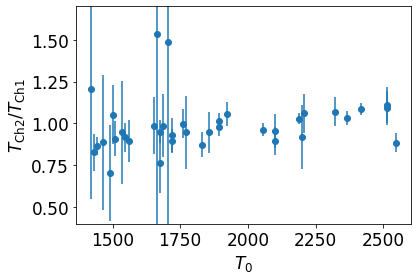

In [29]:
plt.scatter(df_cleaned['T eq'][0:37],summary_ratio['mean'])
plt.errorbar(x=df_cleaned['T eq'][0:37],y=summary_ratio['mean'],yerr=summary_ratio['sd'],linestyle='None')
plt.ylim(0.4,1.7)
plt.ylabel(r'$T_{\rm Ch 2}/T_{\rm Ch 1}$')
plt.xlabel(r'$T_{0}$')

# The hierarchical models

The first model will be a wavelength independent hierarchical model--- a common hierarchical distribution for both channels. 

In [30]:
with pm.Model() as model_hier_ind:
    m_hier_offset = pm.Normal('m hier offset',0,1)
    m_hier = pm.Deterministic('m hier',0.7+0.175*3*m_hier_offset)
    
    m_sig = pm.HalfNormal('m sig',0.5)
    
    m_offset = pm.Normal('m offset',0,1,shape=len(df_cleaned.index))
    m = pm.Deterministic('m',m_hier+m_sig*m_offset)

    #Calculate the brightness temp ratio
    ratio =pm.Deterministic('ratio',m[0:37]/m[37:74])
    #Convert m to brightness temp
    #Tday = pm.Deterministic('Tday',m*Teff[2::]*np.sqrt(1/a[2::]))
    #ED= pm.Deterministic('ED',Planck(4.5e-6,Tday)/BStarCh2[2::]*radius[2::]**2)
    y_= pm.Normal('y ch2',mu=m , sd=df_cleaned['m err'],observed= df_cleaned['m'])

# First do a prior predictive check.

In [34]:
with model_hier_ind:
    ppc_hier_ind =pm.sample_prior_predictive(samples=1000)

Text(0.5, 0, '$T_{0}$')

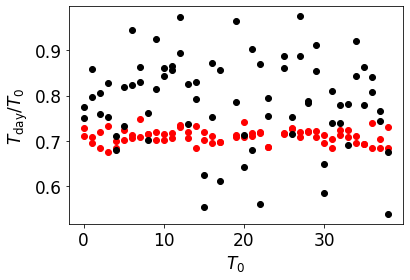

In [37]:
plt.scatter(x=df_cleaned.index,y=np.median(ppc_hier_ind['m'],axis=0),color='red')
plt.scatter(x=df_cleaned.index,y=df_cleaned['m'],color='k')
plt.ylabel(r'$T_{\rm day}/T_{0}$')
plt.xlabel(r'$T_{0}$')

In [38]:
with model_hier_ind:
    trace_hier_ind =pm.sample(draws=1000,tune=1000,chains=4,cores=4,target_accept=0.95)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [m offset, m sig, m hier offset]
Sampling 4 chains, 0 divergences: 100%|██████████| 8000/8000 [00:28<00:00, 283.15draws/s]


In [40]:
summary_hier_ind=pm.summary(trace_hier_ind,var_names=['m'],round_to=7)
summary_ratio_ind=pm.summary(trace_hier_ind,var_names=['ratio'],round_to=7)

# Plot the brightness temperature ratio for each planet.

Text(0.5, 0, '$T_{0}$')

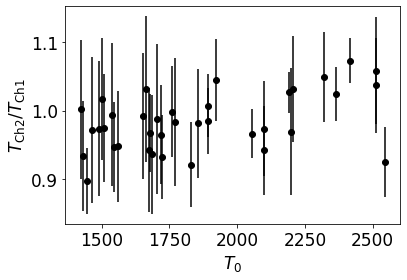

In [43]:
plt.scatter(df_cleaned['T eq'][0:37],summary_ratio_ind['mean'],color='k')
plt.errorbar(x=df_cleaned['T eq'][0:37],y=summary_ratio_ind['mean'],yerr=summary_ratio_ind['sd'],linestyle='None',color='k')
plt.ylabel(r'$T_{\rm Ch 2}/T_{\rm Ch 1}$')
plt.xlabel(r'$T_{0}$')

In [44]:
pm.summary(trace_hier_ind,var_names=['m hier','m sig'],round_to=7)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
m hier,0.808948,0.010381,0.789764,0.828825,0.000309,0.000219,1127.553816,1127.553816,1128.799206,1951.254507,1.003558
m sig,0.062138,0.008731,0.045588,0.077576,0.000241,0.000170,1312.231689,1312.231689,1301.290238,2319.621705,1.006037


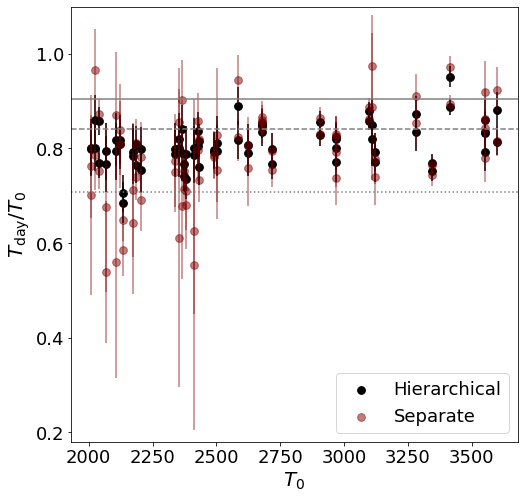

In [46]:

plt.figure(figsize=(8,8))
matplotlib.rcParams.update({'font.size': 18,"axes.labelsize": 20})

plt.errorbar(x=df_cleaned['T eq']/(0.25**0.25),y=summary_hier_ind['mean'],yerr=summary_hier_ind['sd'],linestyle='None',color='k')
plt.scatter(x=df_cleaned['T eq']/(0.25**0.25),y=summary_hier_ind['mean'],color='k',s=60,label='Hierarchical')
plt.errorbar(x=df_cleaned['T eq']/(0.25**0.25),y=df_cleaned['m'],yerr=df_cleaned['m err'],linestyle='None',color='maroon',alpha=0.5)
plt.scatter(x=df_cleaned['T eq']/(0.25**0.25),y=df_cleaned['m'],color='maroon',s=60,alpha=0.5,label='Separate')
plt.axhline((2/3)**0.25,color='gray')
plt.axhline(0.5**0.25,color='gray',linestyle='dashed')
plt.axhline(0.25**0.25,color='gray',linestyle='dotted')
plt.ylabel(r'$T_{\rm day}/T_{0}$')
plt.xlabel(r'$T_{0}$')
plt.ylim(0.18,1.1)
plt.legend(loc=4)
plt.savefig('Garhart_Hier_2channel.pdf',bbox_inches='tight')

# Pack the best fit values into a CSV so I can generate a LaTeX table for the paper.

In [48]:
m_fit = []
garhart_tday = []
garhart_m = []
tdayfit =[]
tirr = []
channel =df_cleaned['Channel']
planet = []
for ind,obs in enumerate(summary_hier_ind['mean']):
    #print(df_cleaned['Planet'].values[ind],obs,summary_hier['sd'][ind])
    planet.append(str(df_cleaned['Planet'].values[ind])+' b')
    tirr.append(str(int((df_cleaned['T eq'].values[ind]/0.25**0.25).round(0)))+'$\pm$'+str(int((df_cleaned['T eq err'].values[ind]/0.25**0.25).round(0))))
    m_fit.append(str(summary_hier_ind['mean'][ind].round(2))+'$\pm$'+str(summary_hier_ind['sd'][ind].round(2)))
    garhart_tday.append(str(int(df_cleaned['Tday'].round(0).values[ind]))+'$\pm'+str(int(df_cleaned['Terr'].round(0).values[ind])))
    tdayfit.append(str(int((summary_hier_ind['mean'][ind]*df_cleaned['T eq'].values[ind]/0.25**0.25).round(0)))+
                  '$\pm$'+str(int((summary_hier_ind['sd'][ind]*df_cleaned['T eq'].values[ind]/0.25**0.25).round(0))))
    garhart_m.append(str((df_cleaned['m'].round(2).values[ind]))+'$\pm'+str(df_cleaned['m err'].round(2).values[ind]))

In [52]:
channel=np.zeros(len(tdayfit))
channel[0:37] = 2
channel[37:74]=1

In [53]:
d = {'Planet':planet,'$T_{0}$':tirr,'Channel':channel.astype(int),
     'Tday':tdayfit,'m':m_fit}

In [54]:
result =pd.DataFrame(d)
result.to_csv('Garhart_2020_Results.csv',index=False)

# Now sample the wavelength dependent model.

In [55]:
with pm.Model() as model_hier_sep:
    m_hier_offset = pm.Normal('m hier offset',0,1,shape=2)
    m_hier = pm.Deterministic('m hier',0.7+0.175*3*m_hier_offset)
    
    m_sig = pm.HalfNormal('m sig',0.5,shape=2)
    
    m_offset = pm.Normal('m offset',0,1,shape=len(df_cleaned.index))
    m = pm.Deterministic('m',m_hier[df_cleaned['Channel']]+m_sig[df_cleaned['Channel']]*m_offset)

    #Convert m to brightness temp
    #Tday = pm.Deterministic('Tday',m*Teff[2::]*np.sqrt(1/a[2::]))
    #ED= pm.Deterministic('ED',Planck(4.5e-6,Tday)/BStarCh2[2::]*radius[2::]**2)
    y_= pm.Normal('y ch2',mu=m , sd=df_cleaned['m err'],observed= df_cleaned['m'])

/Users/dylanskeating/opt/miniconda3/envs/pymc3/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


In [57]:
with model_hier_sep:
    trace_hier_sep =pm.sample(draws=1000,tune=2000,chains=4,cores=4,target_accept=0.95)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [m offset, m sig, m hier offset]
Sampling 4 chains, 0 divergences: 100%|██████████| 12000/12000 [01:05<00:00, 183.08draws/s]
/Users/dylanskeating/opt/miniconda3/envs/pymc3/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


# Compute the WAIC values for the three models and compare.

In [60]:
pm.compare({'Wavelength Independent':trace_hier_ind,'Wavelength Dependent':trace_hier_sep,'sep':trace_sep},ic='waic')

/Users/dylanskeating/opt/miniconda3/envs/pymc3/lib/python3.8/site-packages/arviz/stats/stats.py:150: UserWarning: 
The scale is now log by default. Use 'scale' argument or 'stats.ic_scale' rcParam if you rely on a specific value.
A higher log-score (or a lower deviance) indicates a model with better predictive accuracy.
  warnings.warn(
/Users/dylanskeating/opt/miniconda3/envs/pymc3/lib/python3.8/site-packages/arviz/stats/stats.py:1409: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/Users/dylanskeating/opt/miniconda3/envs/pymc3/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result

,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
Wavelength Dependent,0,89.1382,24.2532,0,0.551016,5.81595,0,True,log
Wavelength Independent,1,88.8771,24.1444,0.261094,0.443954,5.63546,1.77753,True,log
sep,2,77.8668,34.8096,11.2713,0.00503007,5.41318,4.20638,True,log
